In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# シンプルなニューラルネットワークを作る
class SimpleMNISTNet(nn.Module):
    def __init__(self):
        super(SimpleMNISTNet, self).__init__()
        # 28x28=784ピクセル → 128 → 64 → 10クラス
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 画像を1次元に変換
        x = x.view(-1, 784)
        # 活性化関数ReLUを適用
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # 最後は活性化しない（CrossEntropyLossが内部でやる）
        x = self.fc3(x)
        return x

# モデルを作成
model = SimpleMNISTNet()
print(model)  # 構造を確認


SimpleMNISTNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# データの前処理（正規化）
transform = transforms.Compose([
    transforms.ToTensor(),  # 画像をTensorに変換
    transforms.Normalize((0.1307,), (0.3081,))  # 平均と標準偏差で正規化
])

# MNISTデータセットをダウンロード＆読み込み
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoaderでバッチ処理
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# データの形を確認
images, labels = next(iter(train_loader))
print(f"Batch画像の形: {images.shape}")  # torch.Size([64, 1, 28, 28])
print(f"Batchラベルの形: {labels.shape}")  # torch.Size([64])


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.50MB/s]

Batch画像の形: torch.Size([64, 1, 28, 28])
Batchラベルの形: torch.Size([64])


In [3]:
import torch.optim as optim

# 損失関数（CrossEntropyLoss）
criterion = nn.CrossEntropyLoss()

# オプティマイザー（SGD or Adam）
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# または
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# 試しに1バッチだけ学習してみる
model.train()  # 学習モードに
images, labels = next(iter(train_loader))

# 順伝播
outputs = model(images)
loss = criterion(outputs, labels)
print(f"初期Loss: {loss.item()}")

# 逆伝播
optimizer.zero_grad()  # 勾配をリセット
loss.backward()  # 勾配を計算
optimizer.step()  # パラメータを更新

# もう一度同じバッチで計算
outputs = model(images)
loss = criterion(outputs, labels)
print(f"1回更新後のLoss: {loss.item()}")  # 少し下がったはず！


初期Loss: 2.315182685852051
1回更新後のLoss: 2.3097219467163086


In [4]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # 勾配をリセット
        optimizer.zero_grad()

        # 順伝播
        output = model(data)
        loss = criterion(output, target)

        # 逆伝播
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 100バッチごとに進捗を表示
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]'
                  f'\tLoss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [5]:
# デバイスの設定（GPU使えるなら使う）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMNISTNet().to(device)

In [6]:
# 1エポック学習してみる
train_loss = train(model, device, train_loader, optimizer, criterion, epoch=1)
print(f'平均Loss: {train_loss:.4f}')

Epoch: 1 [0/60000]	Loss: 2.318688
Epoch: 1 [6400/60000]	Loss: 2.334344
Epoch: 1 [12800/60000]	Loss: 2.320802
Epoch: 1 [19200/60000]	Loss: 2.300652
Epoch: 1 [25600/60000]	Loss: 2.274307
Epoch: 1 [32000/60000]	Loss: 2.294077
Epoch: 1 [38400/60000]	Loss: 2.306520
Epoch: 1 [44800/60000]	Loss: 2.322717
Epoch: 1 [51200/60000]	Loss: 2.319300
Epoch: 1 [57600/60000]	Loss: 2.313701
平均Loss: 2.3129


In [7]:
# Day 5/6 のコードの続きとして追記
train_losses = []  # 訓練時の平均Lossを記録
test_accuracies = [] # テスト時の精度を記録
test_losses = [] # テスト時の平均Lossも記録しておくと、後で過学習の確認に便利です

In [8]:
def test(model, device, test_loader, criterion):
    model.eval()  # 評価モードに
    test_loss = 0
    correct = 0

    with torch.no_grad():  # 勾配計算しない（高速化）
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            # 予測クラスを取得
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.2f}%)')

    return test_loss, accuracy

# テストしてみる
test_loss, accuracy = test(model, device, test_loader, criterion)


Test Loss: 2.3127, Accuracy: 859/10000 (8.59%)


In [9]:
# Day 6 実装ブロックの実行部分
# 訓練実行
train_loss = train(model, device, train_loader, optimizer, criterion, epoch=1)
print(f'平均Loss: {train_loss:.4f}')

# ★ 訓練結果を記録
train_losses.append(train_loss)

# テスト実行 (test関数は test_loss と accuracy を返すように定義しています)
test_loss, accuracy = test(model, device, test_loader, criterion)

# ★ テスト結果を記録
test_losses.append(test_loss)
test_accuracies.append(accuracy)

print("記録完了！")

Epoch: 1 [0/60000]	Loss: 2.277846
Epoch: 1 [6400/60000]	Loss: 2.309104
Epoch: 1 [12800/60000]	Loss: 2.351833
Epoch: 1 [19200/60000]	Loss: 2.310063
Epoch: 1 [25600/60000]	Loss: 2.294736
Epoch: 1 [32000/60000]	Loss: 2.280508
Epoch: 1 [38400/60000]	Loss: 2.309691
Epoch: 1 [44800/60000]	Loss: 2.325188
Epoch: 1 [51200/60000]	Loss: 2.289755
Epoch: 1 [57600/60000]	Loss: 2.326997
平均Loss: 2.3129
Test Loss: 2.3127, Accuracy: 859/10000 (8.59%)
記録完了！


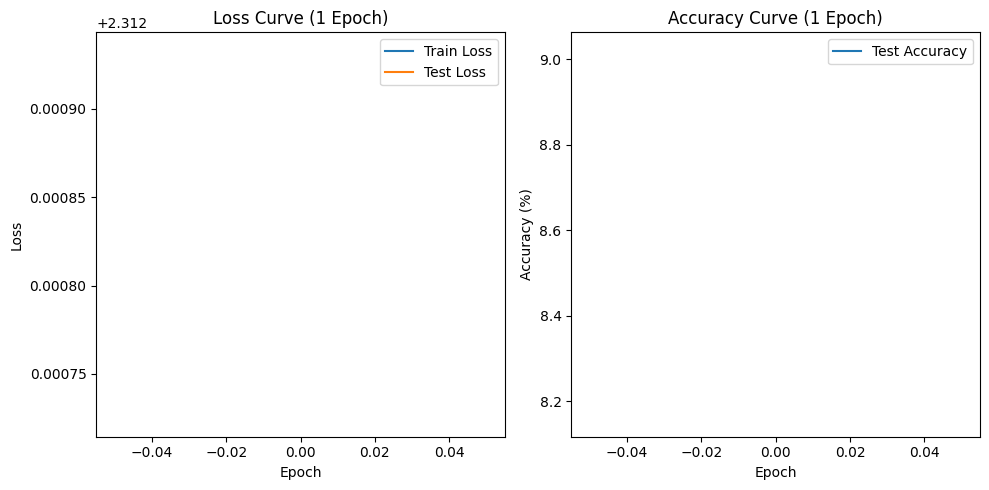

In [10]:
import matplotlib.pyplot as plt

# 損失（Loss）の推移をプロット
plt.figure(figsize=(10, 5))

# 訓練LossとテストLossの推移
plt.subplot(1, 2, 1) # 1行2列の1つ目
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve (1 Epoch)')

# 精度（Accuracy）の推移をプロット
plt.subplot(1, 2, 2) # 1行2列の2つ目
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve (1 Epoch)')

plt.tight_layout()
plt.show()

In [11]:
# ハイパーパラメータの設定
num_epochs = 10
learning_rate = 0.01

# モデルを再初期化
model = SimpleMNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
# 学習ループ
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, accuracy = test(model, device, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

print(f'最終精度: {test_accuracies[-1]:.2f}%')


Epoch: 1 [0/60000]	Loss: 2.317426
Epoch: 1 [6400/60000]	Loss: 0.508971
Epoch: 1 [12800/60000]	Loss: 0.281490
Epoch: 1 [19200/60000]	Loss: 0.317780
Epoch: 1 [25600/60000]	Loss: 0.121612
Epoch: 1 [32000/60000]	Loss: 0.292295
Epoch: 1 [38400/60000]	Loss: 0.163059
Epoch: 1 [44800/60000]	Loss: 0.279502
Epoch: 1 [51200/60000]	Loss: 0.225981
Epoch: 1 [57600/60000]	Loss: 0.129372
Test Loss: 0.1370, Accuracy: 9579/10000 (95.79%)
Epoch: 2 [0/60000]	Loss: 0.096875
Epoch: 2 [6400/60000]	Loss: 0.181439
Epoch: 2 [12800/60000]	Loss: 0.203210
Epoch: 2 [19200/60000]	Loss: 0.208393
Epoch: 2 [25600/60000]	Loss: 0.100257
Epoch: 2 [32000/60000]	Loss: 0.176005
Epoch: 2 [38400/60000]	Loss: 0.192177
Epoch: 2 [44800/60000]	Loss: 0.066964
Epoch: 2 [51200/60000]	Loss: 0.107956
Epoch: 2 [57600/60000]	Loss: 0.042112
Test Loss: 0.1054, Accuracy: 9673/10000 (96.73%)
Epoch: 3 [0/60000]	Loss: 0.101442
Epoch: 3 [6400/60000]	Loss: 0.017455
Epoch: 3 [12800/60000]	Loss: 0.101649
Epoch: 3 [19200/60000]	Loss: 0.209761
Epoch

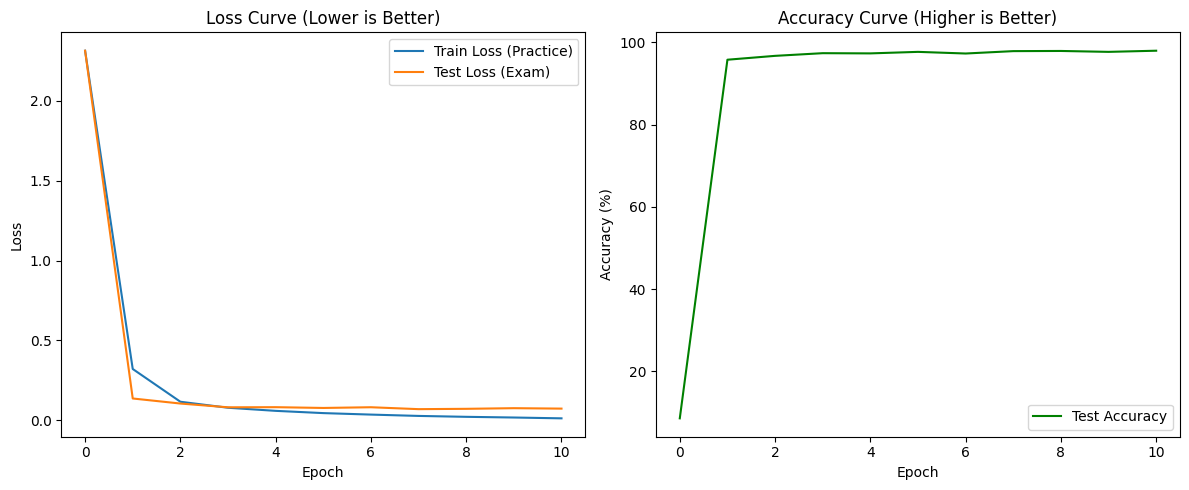

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 左側のグラフ：Loss（失敗の数）の推移
# → 下がっていればOK！
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (Practice)')
plt.plot(test_losses, label='Test Loss (Exam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve (Lower is Better)')

# 右側のグラフ：Accuracy（正解率）の推移
# → 上がっていればOK！
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve (Higher is Better)')

plt.tight_layout()
plt.show()

In [14]:
# モデルの中身（学習した重みパラメータ）を保存
torch.save(model.state_dict(), 'mnist_model.pth')
print("モデルを保存しました！ 'mnist_model.pth' というファイルができています。")

モデルを保存しました！ 'mnist_model.pth' というファイルができています。


In [15]:
# 復元テストのコード
new_model = SimpleMNISTNet() # ← モデルの構造（設計図）は、保存時と同じものを定義する必要がある
new_model.load_state_dict(torch.load('mnist_model.pth')) # ← 保存された重み（学習結果）を読み込む
new_model.eval()

SimpleMNISTNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

🧪 実験スタート！

--- 学習率(lr): 0.001 で実験中 ---
Epoch: 1 [0/60000]	Loss: 2.298368
Epoch: 1 [6400/60000]	Loss: 2.052454
Epoch: 1 [12800/60000]	Loss: 1.253178
Epoch: 1 [19200/60000]	Loss: 0.732902
Epoch: 1 [25600/60000]	Loss: 0.483011
Epoch: 1 [32000/60000]	Loss: 0.473466
Epoch: 1 [38400/60000]	Loss: 0.298658
Epoch: 1 [44800/60000]	Loss: 0.498477
Epoch: 1 [51200/60000]	Loss: 0.242563
Epoch: 1 [57600/60000]	Loss: 0.292652
Test Loss: 0.3332, Accuracy: 9051/10000 (90.51%)
Epoch: 2 [0/60000]	Loss: 0.352851
Epoch: 2 [6400/60000]	Loss: 0.386367
Epoch: 2 [12800/60000]	Loss: 0.247283
Epoch: 2 [19200/60000]	Loss: 0.203843
Epoch: 2 [25600/60000]	Loss: 0.316189
Epoch: 2 [32000/60000]	Loss: 0.203953
Epoch: 2 [38400/60000]	Loss: 0.126962
Epoch: 2 [44800/60000]	Loss: 0.417438
Epoch: 2 [51200/60000]	Loss: 0.290178
Epoch: 2 [57600/60000]	Loss: 0.187908
Test Loss: 0.2633, Accuracy: 9224/10000 (92.24%)
Epoch: 3 [0/60000]	Loss: 0.257029
Epoch: 3 [6400/60000]	Loss: 0.352398
Epoch: 3 [12800/60000]	Loss: 0.230857
Epoc

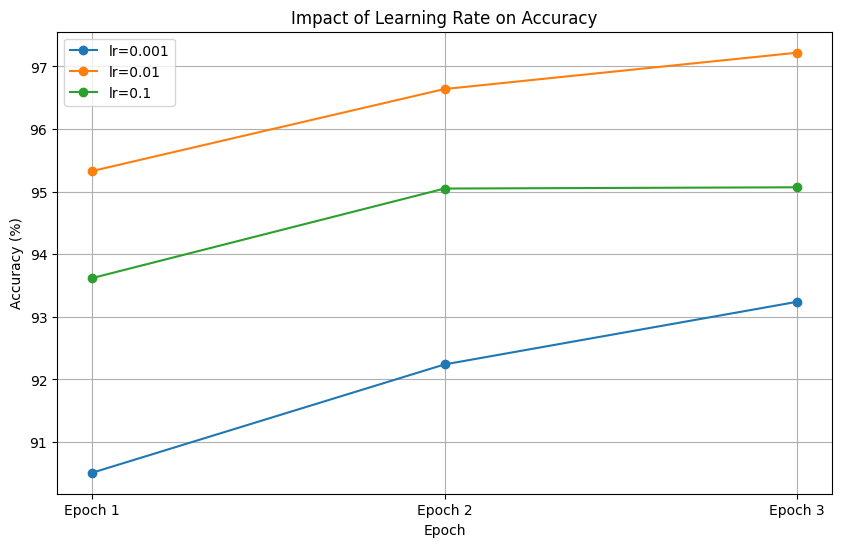

In [16]:
# === ハイパーパラメータ実験：学習率を変えて比較 ===

learning_rates = [0.001, 0.01, 0.1]  # 試す学習率のリスト
histories = {}  # 結果を保存する辞書

print("🧪 実験スタート！")

for lr in learning_rates:
    print(f"\n--- 学習率(lr): {lr} で実験中 ---")

    # 重要！毎回新しいモデルを作ります（前の学習結果をリセットするため）
    model = SimpleMNISTNet().to(device)

    # オプティマイザーの lr を変更して設定
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # このlrでの記録用リスト
    lr_accuracies = []

    # 3エポックだけ回す
    for epoch in range(1, 4):
        # 学習
        train(model, device, train_loader, optimizer, criterion, epoch)
        # テスト
        _, accuracy = test(model, device, test_loader, criterion)
        lr_accuracies.append(accuracy)

    # 結果を保存
    histories[lr] = lr_accuracies

print("\n🎉 全実験終了！グラフを描画します...")

# === 結果の比較グラフを描画 ===
plt.figure(figsize=(10, 6))

for lr, accuracies in histories.items():
    plt.plot(accuracies, marker='o', label=f'lr={lr}')

plt.title('Impact of Learning Rate on Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks([0, 1, 2], ['Epoch 1', 'Epoch 2', 'Epoch 3']) # 目盛りを合わせる
plt.legend()
plt.grid(True)
plt.show()